In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
#from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt
%matplotlib inline

tf.logging.set_verbosity(tf.logging.INFO)

In [2]:
mnist = input_data.read_data_sets("./",one_hot=True)


print(mnist.train.images.shape)
print(mnist.train.labels.shape)

print(mnist.validation.images.shape)
print(mnist.validation.labels.shape)

print(mnist.test.images.shape)
print(mnist.test.labels.shape)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(55000, 784)
(55000, 10)
(5000, 784)
(5000, 10)
(10000, 784)
(10000, 10)


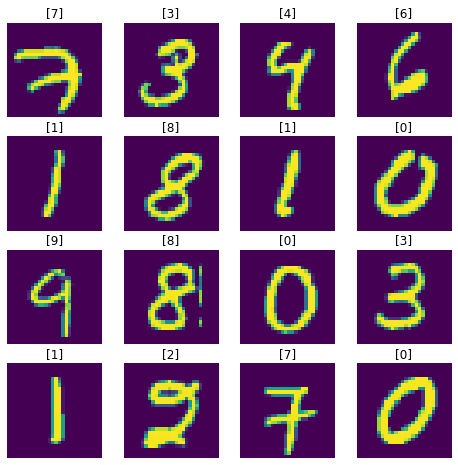

In [3]:
plt.figure(figsize=(8,8))

for idx in range(16):
    plt.subplot(4,4,idx + 1)
    plt.axis('off')
    plt.title('[{}]'.format(np.argmax(mnist.train.labels[idx])))#因为用过onehot,所以用argmax处理一下。
    plt.imshow(mnist.train.images[idx].reshape((28,28)))
    

In [4]:
x = tf.placeholder('float',[None,784],name='x') #第一个placeholder代表输入的图片
y = tf.placeholder('float',[None,10],name='y') #第二个图片代表输入图片的标签

因为输入的图片是展开后的一维向量，所以第一步就是需要把一维向量还原为二维的图片

In [5]:
x_image = tf.reshape(x,[-1,28,28,1])

接下来我们定义第一个卷积层，使用6个5×5 的卷积核对输入数据进行卷积，padding方式选为valid，所以输出数据的宽高变为24×24，但是深度已经有原来的1变成了6.卷积后使用的激活函数为relu。

In [6]:
with tf.name_scope('conv1'):
    C1 = tf.contrib.slim.conv2d(
         x_image,6,[5,5],padding='VALID',activation_fn=tf.nn.relu)
    #六个卷积核

接下来进行stride为2的最大池化，池化后，输出深度不变，但是长宽减半，所以输出变为12×12，深度为6.

In [8]:
with tf.name_scope('pool1'):
    S2 = tf.contrib.slim.max_pool2d(C1,[2,2],stride=[2,2],padding='VALID')

接下来我们定义第二个卷积层，使用16个5×5的卷积核对数据进行卷积，padding方式还是选择valid，输出8*8，深度为16，那本层的卷积激活函数选择relu。

In [10]:
with tf.name_scope('conv2'):
    C3 = tf.contrib.slim.conv2d(
    S2,16,[5,5],padding='VALID',activation_fn=tf.nn.relu)

在进行一次stride为2的最大池化，输出4×4，深度16.

In [12]:
with tf.name_scope('pool2'):
    S4 = tf.contrib.slim.max_pool2d(C3,[2,2],stride=[2,2],padding='VALID')

经过上述的几步操作，得到的是一个三维的数据，这里将做一个拉平的操作，将三维的数据展开至1维，然后送入两层全连接，
全连接隐层的神经元数量分别为120,84。

In [14]:
with tf.name_scope('fc1'):
    S4_flat = tf.contrib.slim.flatten(S4)
    C5 = tf.contrib.slim.fully_connected(
        S4_flat,120,activation_fn=tf.nn.relu)
    
with tf.name_scope('fc2'):
    F6 = tf.contrib.slim.fully_connected(C5,84,activation_fn=tf.nn.relu)

1.这里需要对全连接的部分增加一个0.6的dropout,以40%的概率丢弃特征中的某些数据
这样可以提高网络的推广能力，减少过拟合的可能。
需要注意的是，dropout仅在训练的时候用，验证的时候需要关闭dropout，所以验证的时候keep_prob是1.0.
dropout的输出最终送入一个隐层为10的全连接层，这个全连接层即为最后输出的0-9的十个数字。

In [16]:
with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(name='keep_prob',dtype=tf.float32)
    F6_drop = tf.nn.dropout(F6,keep_prob)

with tf.name_scope('fc3'):
    logits = tf.contrib.slim.fully_connected(F6_drop,10,activation_fn=None)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


接下来定义loss和用于进行优化的优化器，使用sofmax激活，计算交叉熵损失。使用了sgd的优化器，使用的学习率为0.3。

In [20]:
cross_entropy_loss = tf.reduce_mean(
tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y))

l2_loss = tf.add_n([
    tf.nn.l2_loss(w)
    for w in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
])
for w in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
    print(w.name)
    tf.summary.histogram(w.name, w)

total_loss = cross_entropy_loss + 7e-5 * l2_loss
tf.summary.scalar('cross_entropy_loss',cross_entropy_loss)
tf.summary.scalar('l2_loss',l2_loss)
tf.summary.scalar('total_loss',total_loss)

optimizer = tf.train.GradientDescentOptimizer(
learning_rate = 0.3).minimize(total_loss)

Conv/weights:0
INFO:tensorflow:Summary name Conv/weights:0 is illegal; using Conv/weights_0 instead.
Conv/biases:0
INFO:tensorflow:Summary name Conv/biases:0 is illegal; using Conv/biases_0 instead.
Conv_1/weights:0
INFO:tensorflow:Summary name Conv_1/weights:0 is illegal; using Conv_1/weights_0 instead.
Conv_1/biases:0
INFO:tensorflow:Summary name Conv_1/biases:0 is illegal; using Conv_1/biases_0 instead.
fully_connected/weights:0
INFO:tensorflow:Summary name fully_connected/weights:0 is illegal; using fully_connected/weights_0 instead.
fully_connected/biases:0
INFO:tensorflow:Summary name fully_connected/biases:0 is illegal; using fully_connected/biases_0 instead.
fully_connected_1/weights:0
INFO:tensorflow:Summary name fully_connected_1/weights:0 is illegal; using fully_connected_1/weights_0 instead.
fully_connected_1/biases:0
INFO:tensorflow:Summary name fully_connected_1/biases:0 is illegal; using fully_connected_1/biases_0 instead.
fully_connected_2/weights:0
INFO:tensorflow:Summ

需要注意的是，上面的网络，最后输出的是未经softmax的原始logits，而不是概率分布，要想看到概率分布，还需要
做一下softmax。
将输出结果与正确结果进行对比，即可得到我们网络输出与结果的准确率。

In [22]:
pred = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(y,1),tf.argmax(logits,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

saver,用于保存或恢复训练的模型。

In [23]:
batch_size = 100
training_step = 1100
saver = tf.train.Saver()

以上为定义好的运算图，并没有导入数据进行实例化。需要创建一个session进行运算。

In [38]:
merged = tf.summary.merge_all()
with tf.Session() as sess:

    writer = tf.summary.FileWriter("logs/", sess.graph)

    sess.run(tf.global_variables_initializer())

    #定义验证集与测试集
    validate_data = {
        x: mnist.validation.images,
        y: mnist.validation.labels,
        keep_prob: 1.0
    }
    test_data = {x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0}

    for i in range(training_step):
        xs, ys = mnist.train.next_batch(batch_size)
        _, loss, rs = sess.run(
            [optimizer, cross_entropy_loss, merged],
            feed_dict={
                x: xs,
                y: ys,
                keep_prob: 0.6
            })
        writer.add_summary(rs, i)

        #每100次训练打印一次损失值与验证准确率
        if i > 0 and i % 100 == 0:
            validate_accuracy = sess.run(accuracy, feed_dict=validate_data)
            print(
                "after %d training steps, the loss is %g, the validation accuracy is %g"
                % (i, loss, validate_accuracy))
            saver.save(sess, './model.ckpt', global_step=i)

    print("the training is finish!")
    #最终的测试准确率
    acc = sess.run(accuracy, feed_dict=test_data)
    print("the test accuarcy is:", acc)

after 100 training steps, the loss is 0.378259, the validation accuracy is 0.9166
after 200 training steps, the loss is 0.254762, the validation accuracy is 0.9546
after 300 training steps, the loss is 0.178049, the validation accuracy is 0.9656
after 400 training steps, the loss is 0.101303, the validation accuracy is 0.9696
after 500 training steps, the loss is 0.260074, the validation accuracy is 0.9692
after 600 training steps, the loss is 0.152453, the validation accuracy is 0.975
Instructions for updating:
Use standard file APIs to delete files with this prefix.
after 700 training steps, the loss is 0.0997168, the validation accuracy is 0.978
after 800 training steps, the loss is 0.0805616, the validation accuracy is 0.9782
after 900 training steps, the loss is 0.0253835, the validation accuracy is 0.9802
after 1000 training steps, the loss is 0.0454261, the validation accuracy is 0.9814
the training is finish!
the test accuarcy is: 0.9775


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model.ckpt-1000
1.0


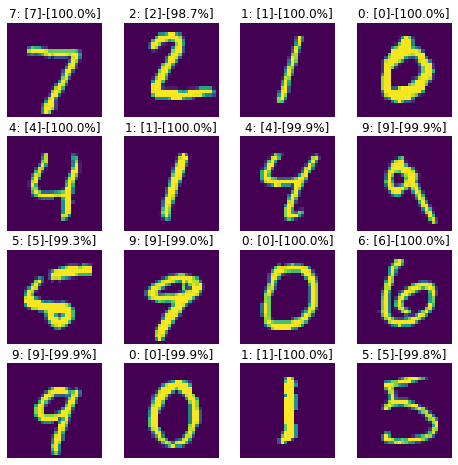

In [39]:
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state('./')
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        final_pred, acc = sess.run(
            [pred, accuracy],
            feed_dict={
                x: mnist.test.images[:16],
                y: mnist.test.labels[:16],
                keep_prob: 1.0
            })
        orders = np.argsort(final_pred)
        plt.figure(figsize=(8, 8))
        print(acc)
        for idx in range(16):
            order = orders[idx, :][-1]
            prob = final_pred[idx, :][order]
            plt.subplot(4, 4, idx + 1)
            plt.axis('off')
            plt.title('{}: [{}]-[{:.1f}%]'.format(
                np.argmax(mnist.test.labels[idx]), order, prob * 100))
            plt.imshow(mnist.test.images[idx].reshape((28, 28)))

    else:
        pass